# Prediction

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import pymc as pm
from quap import quap
import statsmodels.formula.api as sm
import arviz as az
import seaborn as sns
from matplotlib import pyplot as plt
import pytensor.tensor as pt
from scipy.special import expit as logistic

import warnings
warnings.filterwarnings("ignore")

palette=['cyan', "#e06666"]
%config InlineBackend.figure_format = 'svg'

In [2]:
def standardize(x):
    return (x - x.mean()) / x.std()

def rescale(series, mean, std):
    return series * std + mean

## Fitting Curves

### Polynomial Linear Models

In [3]:
df = pd.read_csv("Data/Howell1.csv", sep=";", header=0)

Quadratic model: $\mu_i = \alpha + \beta_1 H_i + \beta_2 H_i^2$

In [4]:
H_std = standardize(df.height)
W_std = standardize(df.weight)

with pm.Model() as model:
    a = pm.Normal("a")
    b1 = pm.Normal("b1")
    b2 = pm.Normal("b2")
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + b1 * H_std + b2 * H_std**2)
    pm.Normal("y", mu=mu, sigma=sigma, observed=W_std)
    
    idata, _ = quap([a, b1, b2, sigma])

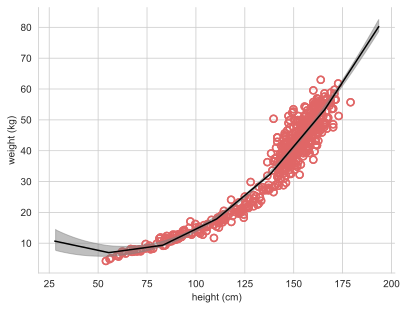

In [5]:
sns.scatterplot(x=df.height, y=df.weight, color=palette[1], edgecolor=palette[1], facecolor="none", s=50, linewidth=1.5)
plt.xlabel("height (cm)")
plt.ylabel("weight (kg)")

height_seq = np.arange(-4, 3)
idata_thinned = az.extract_dataset(idata, num_samples=1000)

mu_pred = np.zeros((len(height_seq), idata_thinned.sizes["sample"]))
a_values = idata_thinned.a.values
b1_values = idata_thinned.b1.values
b2_values = idata_thinned.b2.values

for i, h in enumerate(height_seq):
    mu_pred[i] = a_values + b1_values * h + b2_values * h**2
    mu_pred[i] = mu_pred[i] * df.weight.std() + df.weight.mean()

mu_mean = mu_pred.mean(1)

sns.scatterplot(x=df.height, y=df.weight, color=palette[1], edgecolor=palette[1], facecolor="none", s=50, linewidth=1.5)
raw_height_seq = height_seq * df.height.std() + df.height.mean()
plt.plot(raw_height_seq, mu_mean, color='black')
az.plot_hdi(raw_height_seq, mu_pred.T, color='grey')
plt.xlabel("height (cm)")
plt.ylabel("weight (kg)")
sns.despine()

## Leave-one-out cross-validation

In [6]:
def do_loo(mass, brainvol, mass_mean, mass_sd, bv_mean, bv_sd, loo_i, order=1, beta_sd=10):
    '''Computes results of LOO CV for sample i of observations
    
    mass: standardized body mass observations
    brainvol: standardized brain volume observations
    mass_mean: average body mass for observations
    mass_sd: standard deviation of body mass observations 
    bv_mean: average brain volume for observations 
    bv_sd: standard deviation of brain volume observations
    order: polynomial order of the model
    beta_sd: standard deviation for the Normal prior on beta
    
    return:
    results_dict: contains values computed in leave-one-out round i
    '''
    
    # leave out data point i
    brain_std = pd.concat([brainvol.iloc[:loo_i], brainvol.iloc[loo_i+1:]])
    mass_std = pd.concat([mass.iloc[:loo_i], mass.iloc[loo_i+1:]])
    
    # sample from the posterior using quadratic approximation
    with pm.Model() as m_loo:
        alpha = pm.Normal("a", 0.5, 1)
        beta = pm.Normal("b", 0, beta_sd, shape=order)
        log_sigma = pm.Normal("log_sigma", 0, 1)
        
        # np.newaxis provides the correct shape for each of the polynomial terms for dot product below
        M = pt.concatenate([mass_std.values[np.newaxis,:] ** val for val in range(1, order+1)])
        
        # np.newaxis needed so dimensions of tensors match
        mu = pm.Deterministic("mu", alpha + pm.math.dot(beta, M))
        B = pm.Normal("brain", mu, np.exp(log_sigma), observed=brain_std)
        
        idata, _ = quap([alpha, beta, log_sigma])
        
    # standardized mass values
    mass_seq = np.linspace(-2, 2)
    
    # thin out the samples
    post = az.extract(idata, num_samples=1000)
    
    pred_mu = np.zeros((len(mass_seq), post.a.shape[0])) 
    # calculate posterior mean
    for j, m in enumerate(mass_seq):
        m_vec = np.array([m ** val for val in range(1, order+1)])
        # need the betas to be at least 2 dimensions (not the case when using first-order model)
        pred_mu[j, :] = post.a.values + np.dot(np.atleast_2d(post.b.values).T, m_vec)
    
    # convert back to original scales
    mass_seq_unstd = rescale(mass_seq, mass_mean, mass_sd)
    brainvol_post_mean = rescale(pred_mu.mean(axis=1), bv_mean, bv_sd)
    mass_unstd = rescale(mass_std, mass_mean, mass_sd)
    bv_unstd = rescale(brain_std, bv_mean, bv_sd)
    mass_loo = rescale(mass.iloc[loo_i], mass_mean, mass_sd)
    bv_loo = rescale(brainvol.iloc[loo_i], bv_mean, bv_sd)
    
    # compute the predicted (standardized) observation values across samples 
    pred_bv_std = np.zeros((len(mass_std), ))

    for j, m in enumerate(mass_std):
        m_vec = np.array([m ** val for val in range(1, order+1)])
        pred_bv_std[j] = np.mean(post.a.values + np.dot(np.atleast_2d(post.b.values).T, m_vec))
    
    pred_bv = rescale(pred_bv_std, bv_mean, bv_sd)
    
    # compute the predicted (standardized) observation for dropped value across samples
    m_vec = np.array([mass.iloc[loo_i] ** val for val in range(1, order+1)])
    loo_pred = rescale(
                    post.a.values + np.dot(np.atleast_2d(post.b.values).T, m_vec),
                    bv_mean, 
                    bv_sd
    ).mean()
        
    
    return dict(
        loo_i=loo_i,
        mass_seq=mass_seq_unstd,
        bv_pred_mu=brainvol_post_mean,
        mass_obs=mass_unstd.values,
        bv_obs=bv_unstd.values,
        mass_loo=mass_loo,
        bv_loo=bv_loo,
        in_pred_bv=pred_bv,
        loo_pred=loo_pred
    )

In [7]:
def plot_loo(all_results, loo_i, out_sample_error=False, in_sample_errors=True, prev_fits=[], marker_color='w', ylim=[200, 1400]):
    '''Generates plots for LOO CV
    
    all_results: model results from each round of LOO CV
    loo_i: the dropped point index
    out_sample_error: flag for plotting the error from predicting dropped point
    in_sample_errors: flag for plotting the errors to posterior mean regression line
    prev_fits: the previous rounds of LOO CV to include in plot
    '''
    
    loo_result = all_results[loo_i]

    # samples used for model
    plt.scatter(loo_result["mass_obs"], loo_result["bv_obs"], marker = "o", facecolors='none', color=marker_color, lw=3)
    
    
    
    if loo_i > -1:
        # left out sample
        plt.scatter(loo_result["mass_loo"], loo_result["bv_loo"], marker = "o", facecolors='none', color="#e06666", lw=3)
        
        # posterior mean of in-sample values
        plt.plot(loo_result["mass_seq"], loo_result["bv_pred_mu"], color='w', zorder=1)
        plt.plot(loo_result["mass_seq"], loo_result["bv_pred_mu"], color="#e06666", alpha=0.5, lw=10, solid_capstyle='round', zorder=1)
    
    else:
        # no left out samples
        
        # last LOO round does not include this point ... add it to the plot
        plt.scatter(loo_result["mass_loo"], loo_result["bv_loo"], marker = "o", facecolors='none', color=marker_color, lw=3)
        
        # collect all posterior means from LOO CV rounds
        pred_mu = np.array([result["bv_pred_mu"] for result in all_results])

        plt.plot(all_results[0]["mass_seq"], pred_mu.mean(axis=0), color="cyan", lw=10, alpha=0.7, zorder=3)
    
    if in_sample_errors:
        # error/residual for in-sample values
        for i in range(len(loo_result["in_pred_bv"])):
        
            err = loo_result["bv_obs"][i] - loo_result["in_pred_bv"][i]
            ys = np.where(
                        err < 0, 
                        [loo_result["in_pred_bv"][i], loo_result["bv_obs"][i]], 
                        [loo_result["bv_obs"][i], loo_result["in_pred_bv"][i]]
            )
            plt.plot(
                np.array([loo_result["mass_obs"][i]] * 2), 
                np.array(ys),
                color='w', 
                linestyle="--"
            )
            
    if out_sample_error:
        # predicted value
        plt.scatter(loo_result["mass_loo"], loo_result["loo_pred"], marker = "o", color="#e06666", zorder=2)
        
        # error/residual for dropped value
        err = loo_result["bv_loo"] - loo_result["loo_pred"]
        ys = np.where(
                err < 0, 
                [loo_result["loo_pred"], loo_result["bv_loo"]], 
                [loo_result["bv_loo"], loo_result["loo_pred"]]
        )
        plt.plot(
                np.array([loo_result["mass_loo"]] * 2), 
                np.array(ys),
                color='w', 
                linestyle="--",
                zorder=1
        )
    
    for j in prev_fits:
        
        loo_result = all_results[j]
        loo_i = all_results[j]["loo_i"]
 
        # posterior mean of in-sample values
        plt.plot(loo_result["mass_seq"], loo_result["bv_pred_mu"], color="gray", lw=4, alpha=0.7, zorder=1)
        
        # prediction of dropped value
        plt.scatter(loo_result["mass_loo"], loo_result["loo_pred"], marker = "o", color="#e06666", zorder=2)
        
        # error/residual for dropped value
        err = loo_result["bv_loo"] - loo_result["loo_pred"]
        ys = np.where(
            err < 0, 
            [loo_result["loo_pred"], loo_result["bv_loo"]], 
            [loo_result["bv_loo"], loo_result["loo_pred"]]
        )
        plt.plot(
            np.array([loo_result["mass_loo"]] * 2), 
            np.array(ys),
            color='grey', 
            linestyle="--",
            zorder=1
        )
        

 
    plt.ylim(ylim)
    plt.xlabel("mass (kg)")
    plt.ylabel("brain volume (cc)")
    sns.despine()

In [8]:
# data to get started
spp_names = [
        "afarensis","africanus","habilis","boisei",
        "rudolfensis","ergaster","sapiens"
]

brainvol_cc = np.array([438 , 452 , 612, 521, 752, 871, 1350])
mass_kg = np.array([37.0 , 35.5 , 34.5 , 41.5 , 55.5 , 61.0 , 53.5 ])

df = pd.DataFrame(
                dict(
                    species=spp_names, brain=brainvol_cc, mass=mass_kg
                )
)
df.sort_values(by=["mass"], inplace=True)
df["B"] = standardize(df.brain)
df["M"] = standardize(df.mass)

df

,species,brain,mass,B,M
2,habilis,612,34.5,-0.315640,-1.008722
1,africanus,452,35.5,-0.812153,-0.917020
0,afarensis,438,37.0,-0.855597,-0.779467
3,boisei,521,41.5,-0.598032,-0.366808
6,sapiens,1350,53.5,1.974524,0.733616
4,rudolfensis,752,55.5,0.118808,0.917020
5,ergaster,871,61.0,0.488090,1.421380


In [9]:
results = [None] * len(df)
for i in range(len(df)):
    results[i] = do_loo(df["M"], df["B"], mass_kg.mean(), mass_kg.std(), brainvol_cc.mean(), brainvol_cc.std(), i, 1)

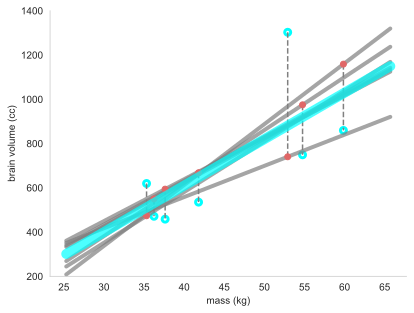

In [10]:
plot_loo(results, -1, out_sample_error=False, in_sample_errors=False, prev_fits=range(7), marker_color="cyan")
sns.despine()
plt.grid(False)

In [11]:
results

[{'loo_i': 0,
  'mass_seq': array([25.30806384, 26.1322245 , 26.95638516, 27.78054582, 28.60470648,
         29.42886714, 30.2530278 , 31.07718846, 31.90134912, 32.72550978,
         33.54967044, 34.3738311 , 35.19799176, 36.02215242, 36.84631308,
         37.67047374, 38.49463439, 39.31879505, 40.14295571, 40.96711637,
         41.79127703, 42.61543769, 43.43959835, 44.26375901, 45.08791967,
         45.91208033, 46.73624099, 47.56040165, 48.38456231, 49.20872297,
         50.03288363, 50.85704429, 51.68120495, 52.50536561, 53.32952626,
         54.15368692, 54.97784758, 55.80200824, 56.6261689 , 57.45032956,
         58.27449022, 59.09865088, 59.92281154, 60.7469722 , 61.57113286,
         62.39529352, 63.21945418, 64.04361484, 64.8677755 , 65.69193616]),
  'bv_pred_mu': array([ 244.51333968,  263.37829455,  282.24324941,  301.10820428,
          319.97315915,  338.83811402,  357.70306889,  376.56802375,
          395.43297862,  414.29793349,  433.16288836,  452.02784322,
          4

In [12]:
# Computes out-of-sample RMSE prediction error
def pred_error(pred, obs):
    return np.sqrt(np.sum((pred - obs) ** 2) / len(pred))

$RMSE$ $=$ $\sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$

### Out-of-sample error from prediction on dropped points

In [13]:
out_error = pred_error(np.array([result['loo_pred'] for result in results]), df.brain)
print(out_error)

pd.DataFrame(data ={"obs": df.brain, 
                    "pred": np.array([result['loo_pred'] for result in results])})

287.64281065405527


,obs,pred
2,612,473.593512
1,452,549.885392
0,438,594.096426
3,521,668.074736
6,1350,740.244706
4,752,975.014463
5,871,1158.917971


In [14]:
df.brain

2     612
1     452
0     438
3     521
6    1350
4     752
5     871
Name: brain, dtype: int32

### In-sample error form fitting to retained points

In [15]:
def in_sample_error(resids, obs):
    loo_errors = np.sqrt(np.sum((resids - obs) **2, axis=1) / resids.shape[1])
    return loo_errors.mean()

In [16]:
# in_pred_bv is the predicted value for each observation in the sample
# bv_obs is the observed value for each observation in the sample
in_error = in_sample_error(np.array([result['in_pred_bv'] for result in results]),
                           np.array([result['bv_obs'] for result in results]))
in_error

184.86537457644974

In [17]:
np.array([result['in_pred_bv'] for result in results])

array([[ 494.78544128,  526.57333518,  621.93701688,  876.24016807,
         918.6240266 , 1035.17963756],
       [ 531.53815888,  577.40624247,  659.96879294,  880.1355942 ,
         916.83006108, 1017.73984499],
       [ 550.31097792,  567.82515727,  672.91023334,  883.0803855 ,
         918.10874419, 1014.4367306 ],
       [ 539.47478192,  557.846204  ,  585.40333711,  888.5318014 ,
         925.27464555, 1026.31746698],
       [ 492.22809915,  505.28160479,  524.86186324,  583.60263859,
         766.35171746,  838.14599844],
       [ 509.05373018,  531.24233651,  564.52524599,  664.37397444,
         930.63725032, 1097.05179774],
       [ 483.82626091,  509.3014198 ,  547.51415813,  662.15237313,
         967.85427978, 1018.80459755]])

In [18]:
np.array([result['bv_obs'] for result in results])

array([[ 471.4139396 ,  458.45245821,  535.29552649, 1302.8003892 ,
         749.15996953,  859.33256141],
       [ 619.54515557,  458.45245821,  535.29552649, 1302.8003892 ,
         749.15996953,  859.33256141],
       [ 619.54515557,  471.4139396 ,  535.29552649, 1302.8003892 ,
         749.15996953,  859.33256141],
       [ 619.54515557,  471.4139396 ,  458.45245821, 1302.8003892 ,
         749.15996953,  859.33256141],
       [ 619.54515557,  471.4139396 ,  458.45245821,  535.29552649,
         749.15996953,  859.33256141],
       [ 619.54515557,  471.4139396 ,  458.45245821,  535.29552649,
        1302.8003892 ,  859.33256141],
       [ 619.54515557,  471.4139396 ,  458.45245821,  535.29552649,
        1302.8003892 ,  749.15996953]])

For simple models, increasing parameters improves fit to sample date, but may reduce accuracy of predictions out of sample.

## Regularization
$\mu_i = \alpha + \sum_{j=1}^{m} \beta_j x_i^j$,  
$\beta_j \sim Normal(0, \sigma)$.

How to choose width of the prior ($\sigma$)?  
For **causal inference**, use science/prior knowledge.  
For **pure prediction** , can tune the prior using cross-validation.

No need to be perfect, don't use flat priors.

## Alternative Predictive Criteria

### Bayesian Cross-Validation
**log pointwise predictive (cross validation) density**: ${\rm lppd_{CV}}=\sum_{i=1}^{N} \frac{1}{S} \sum_{s=1}^{S} {\rm log} Pr(y_i | \Theta_{-i,s})$, where $N$ is the number of observed data points, $S$ is the number of samples from the posterior. ${\rm log} Pr(y_i | \Theta_{-i,s})$ represents the log probability of the $i$th observation computed with posterior that omits the $i$th observation; $\frac{1}{S} \sum_{s=1}^{S} {\rm log} Pr(y_i | \Theta_{-i,s})$ represents the average log probability of the $i$th observation. Observations with higher predictive probabilities (for each sample) increase score, which indicates better performance.  

  
**deviance**: $ = -2 \times {\rm lppd_{CV}}$

### Prediction Penalty
Out-of-sample prediction penalty equals the difference between tht out-of-sample error and in-sample error. For $N$ data points, cross validation requires fitting $N$ models. What if we could compute the penalty from a single model fit? There are two options: **importance sampling** and the **information criterion (WAIC)**.

### Importance Sampling
Use a single posterior distribution for $N$ points to sample from each posterior for $N-1$ points.

### Akaike Information Criterion (AIC)
$AIC = -2 \times {\rm lppd} + 2k$, where ${\rm lppd}$ is the log pointwise predictive density (uses posterior predictive) and $k$ is the number of parameters in the model (penalty).

### Widely Applicable Information Criterion (WAIC)
$ {\rm WAIC}(y, \Theta) = -2 \times {\rm lppd} + \sum_{i} {\rm var}_{\Theta} {\rm log} p(y_i | \Theta)$

## Outlier Analysis
Outliers: observations in tails of predictive distribution